# Simple RNN

In ths notebook, we're going to train a simple RNN to do **time-series prediction**. Given some set of input data, it should be able to generate a prediction for the next time step!
<img src='assets/time_prediction.png' width=40% />

> * First, we'll create our data
* Then, define an RNN in PyTorch
* Finally, we'll train our network and see how it performs

### Import resources and create data 

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data

We will look at a clean sinus signal at first and investigate the memorysation effect of a LSTM there. We want to predict the next time step in the future given some past. We will move to more complex examples later.

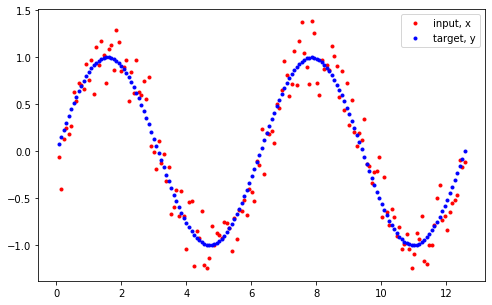

In [5]:
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 40

# generate evenly spaced data pts
times_pi = 4
shown_seq_length = times_pi*(seq_length + 1)
time_steps = np.linspace(0, times_pi*np.pi, shown_seq_length)
mu_noise, sigma_noise = 0, 0.2
noise = np.random.normal(mu_noise, sigma_noise, shown_seq_length)
data = np.sin(time_steps)
noisy_data = data+noise
data.resize((shown_seq_length, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = noisy_data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

---
## Define the LSTM

Next, we define an RNN in PyTorch. We'll use `nn.LSTM` to create an RNN (LSTM) layer, then we'll add a last, fully-connected layer to get the output size that we want. `nn.LSTM` takes similar parameters as a vanillia RNN:
* **input_size** - the size of the input
* **hidden_dim** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* **dropout** - a dropout probability for each of the gates (also known as AWD-LSTM)
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)

Take a look at the [LSTM documentation](https://pytorch.org/docs/stable/nn.html#lstm) to read more.

In [6]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


In [7]:
class SinusoidLSTM(nn.Module):
    
    def __init__(self, input_size, output_size, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.input_size = input_size
        
        ## TODO: define the layers of the model
        self.lstm = nn.LSTM(input_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        #self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden, output_size)
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
        
        batch_size, sequence_length, input_dim = x.shape
        out, hidden = self.lstm(x, hidden)
        #out = self.dropout(out)
        out = out.contiguous().view(batch_size*sequence_length, self.n_hidden)
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
        

---
## Training the RNN

Next, we'll instantiate an RNN with some specified hyperparameters. Then train it over a series of steps, and see how it performs.

In [8]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=8
n_layers=1

# instantiate an RNN
lstm = SinusoidLSTM(input_size, output_size, hidden_dim, n_layers)
print(lstm)

SinusoidLSTM(
  (lstm): LSTM(1, 8, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)


/home/jsimon/anaconda3/envs/interpretable-time-series/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


### Loss and Optimization

This is a regression problem: can we train an RNN to accurately predict the next data point, given a current data point?

>* The data points are coordinate values, so to compare a predicted and ground_truth point, we'll use a regression loss: the mean squared error.
* It's typical to use an Adam optimizer for recurrent models.

In [9]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001) 

### Defining the training function

This function takes in an rnn, a number of steps to train for, and returns a trained rnn. This function is also responsible for displaying the loss and the predictions, every so often.

#### Hidden State

Pay close attention to the hidden state, here:
* Before looping over a batch of training data, the hidden state is initialized
* After a new hidden state is generated by the rnn, we get the latest hidden state, and use that as input to the rnn for the following steps

In [18]:
# train the RNN
def train(rnn, batch_size, clip, n_steps, print_every):
    
    # initialize the hidden state
    hidden = rnn.init_hidden(4)    
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        computed_seq_length = batch_size*(seq_length + 1)
        time_steps = np.linspace(step * np.pi, (step+batch_size)*np.pi, computed_seq_length).reshape(batch_size, (seq_length + 1))
        data = np.sin(time_steps)
        noise = np.random.normal(mu_noise, sigma_noise, computed_seq_length).reshape(batch_size, (seq_length + 1))
        noisy_data = data+noise
        data.resize((batch_size, (seq_length + 1), 1)) # input_size=1
        noisy_data.resize((batch_size, (seq_length + 1), 1))
        #print(data.shape)
        #print(noisy_data.shape)

        x = noisy_data[:, :-1, :]
        y = data[:, 1:, :].reshape(batch_size*seq_length,)
        #print(x.shape)
        #print(y.shape)
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x)
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = tuple([each.data for each in hidden])

        # calculate the loss
        #print(prediction.shape)
        #print(prediction.squeeze().shape)
        #print(y_tensor.shape)
        loss = criterion(prediction.squeeze(), y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        nn.utils.clip_grad_norm_(rnn.parameters(), clip)
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[:, 1:].reshape(batch_size*seq_length), x.reshape(batch_size*seq_length), 'r.') # input
            plt.plot(time_steps[:, 1:].reshape(batch_size*seq_length), prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn


Loss:  0.02253790944814682


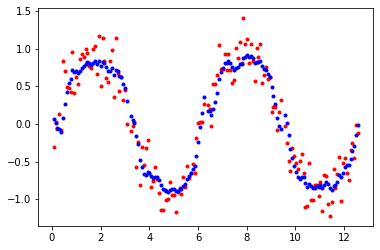

Loss:  0.017795518040657043


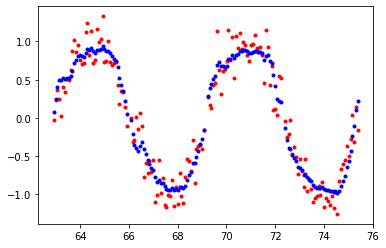

Loss:  0.013896141201257706


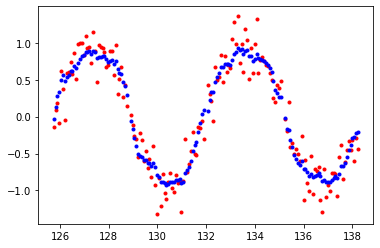

Loss:  0.015943918377161026


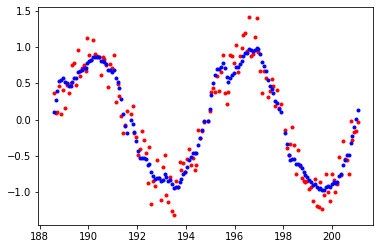

Loss:  0.013759927824139595


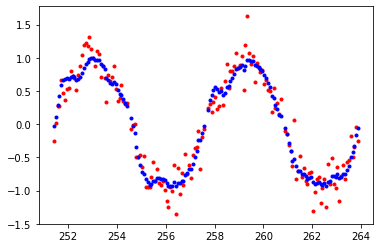

Loss:  0.01655929535627365


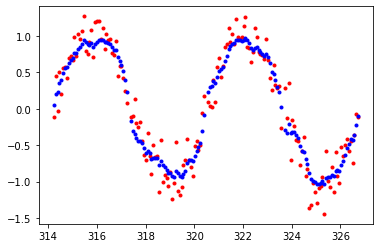

Loss:  0.01599234528839588


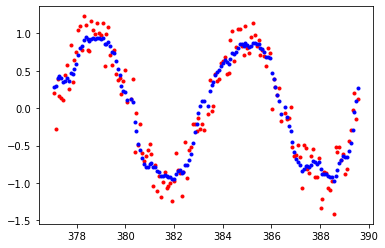

Loss:  0.013398016802966595


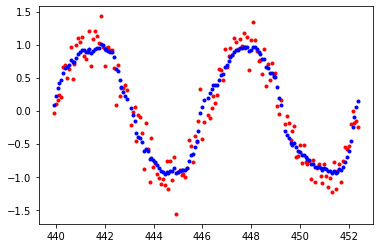

Loss:  0.015313170850276947


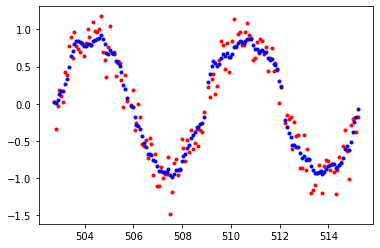

Loss:  0.013048218563199043


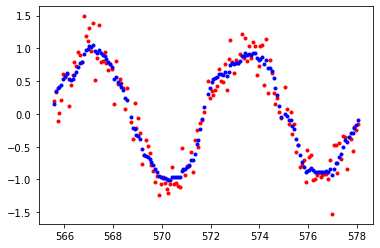

Loss:  0.013904299587011337


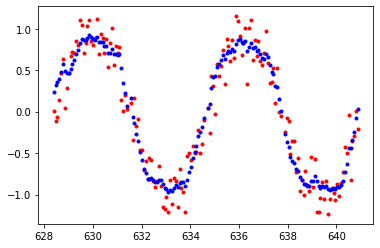

Loss:  0.013647248037159443


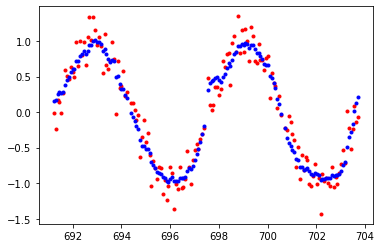

Loss:  0.011252089403569698


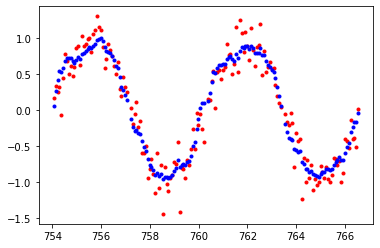

Loss:  0.008545780554413795


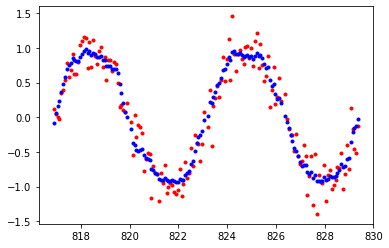

Loss:  0.015367724001407623


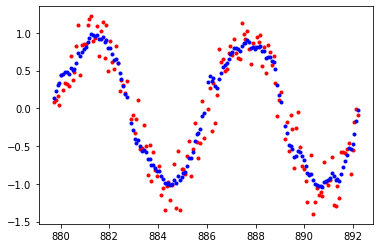

In [19]:
# train the rnn and monitor results
n_steps = 300
print_every = 20
clip=2
batch_size = times_pi

trained_rnn = train(lstm, batch_size, clip, n_steps, print_every)

Loss:  0.015348967164754868


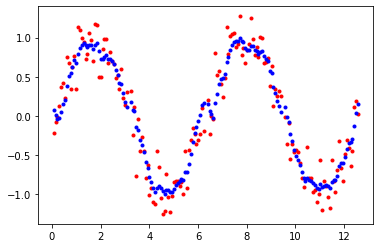

Loss:  0.005760653875768185


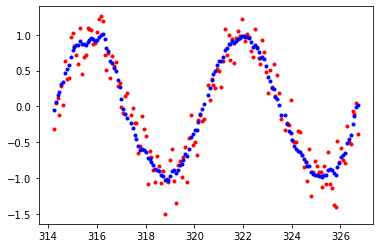

Loss:  0.004098130390048027


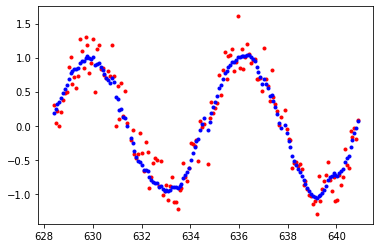

In [20]:
n_steps = 300
print_every = 100
clip=2

trained_rnn = train(lstm, batch_size, clip, n_steps, print_every)

In [23]:
time_steps = np.linspace(0, np.pi, seq_length+1)
noise = np.random.normal(mu_noise, sigma_noise, seq_length+1)
data = np.sin(time_steps)
noisy_data = data+noise

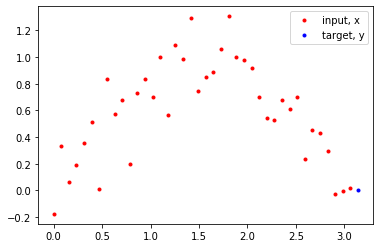

In [25]:
x = noisy_data[:-1] # all but the last piece of data
y = data[-1] # all but the first

# display the data
plt.plot(time_steps[:-1], x, 'r.', label='input, x') # x
plt.plot(time_steps[-1], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [26]:
xt = x.reshape(1,seq_length,1)

In [27]:
xt.shape

(1, 40, 1)

In [28]:
xt = torch.Tensor(xt).cuda() if train_on_gpu else torch.Tensor(xt)

In [29]:
predicted, hidden = lstm(xt, lstm.init_hidden(1))
predicted = predicted.detach().numpy()

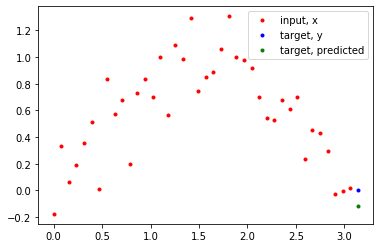

In [30]:
x = noisy_data[:-1] # all but the last piece of data
y = data[-1] # all but the first

# display the data
plt.plot(time_steps[:-1], x, 'r.', label='input, x') # x
plt.plot(time_steps[-1], y, 'b.', label='target, y') # y
plt.plot(time_steps[-1], predicted[-1], 'g.', label='target, predicted') # predicted

plt.legend(loc='best')
plt.show()

In [31]:
state = lstm.state_dict()
print(state)

OrderedDict([('lstm.weight_ih_l0', tensor([[ 0.1972],
        [-0.1928],
        [ 0.0038],
        [-0.4017],
        [ 0.4723],
        [-0.0665],
        [ 0.1844],
        [-0.0103],
        [-0.0159],
        [ 0.1332],
        [-0.2525],
        [-0.4288],
        [ 0.5347],
        [-0.0338],
        [ 0.0398],
        [-0.0363],
        [-0.3105],
        [ 0.4271],
        [ 0.0951],
        [-0.1570],
        [-0.3128],
        [ 0.3413],
        [ 0.3946],
        [-0.2015],
        [ 0.0761],
        [-0.3847],
        [ 0.0649],
        [-0.2226],
        [ 0.6289],
        [ 0.4424],
        [-0.1719],
        [-0.4280]])), ('lstm.weight_hh_l0', tensor([[-5.2423e-01, -1.1966e-01, -2.3545e-01, -8.0059e-02,  2.6365e-02,
         -4.3278e-01,  1.5586e-01, -5.6734e-01],
        [-4.5973e-01, -1.9176e-02, -6.5490e-02, -3.1124e-02, -4.2803e-01,
         -1.6051e-01,  2.5957e-01, -1.0483e-01],
        [-6.0121e-03,  1.5346e-01, -3.5004e-02, -3.9808e-03,  1.8028e-01,
         -3.

Based on this really informative card about [LSTMs inner workings](https://www.gregcondit.com/articles/lstm-ref-card) we can extract the weights and biases form trained LSTMs state dict and redo the calculation

In [32]:
#Event (x) Weights and Biases for all gates
Weights_xi = state['lstm.weight_ih_l0'][0:8].numpy()    # shape  [h, x]
Weights_xf = state['lstm.weight_ih_l0'][8:16].numpy()   # shape  [h, x]
Weights_xl = state['lstm.weight_ih_l0'][16:24].numpy()  # shape  [h, x]
Weights_xo = state['lstm.weight_ih_l0'][24:32].numpy()  # shape  [h, x]

Bias_xi = state['lstm.bias_ih_l0'][0:8].numpy()    #shape is [h, 1]
Bias_xf = state['lstm.bias_ih_l0'][8:16].numpy()   #shape is [h, 1]
Bias_xl = state['lstm.bias_ih_l0'][16:24].numpy()  #shape is [h, 1]
Bias_xo = state['lstm.bias_ih_l0'][24:32].numpy()  #shape is [h, 1]

#Hidden state (h) Weights and Biases for all gates
Weights_hi = state['lstm.weight_hh_l0'][0:8].numpy()    #shape is [h, h]
Weights_hf = state['lstm.weight_hh_l0'][8:16].numpy()   #shape is [h, h]
Weights_hl = state['lstm.weight_hh_l0'][16:24].numpy()  #shape is [h, h]
Weights_ho = state['lstm.weight_hh_l0'][24:32].numpy()  #shape is [h, h]

Bias_hi = state['lstm.bias_hh_l0'][0:8].numpy()    #shape is [h, 1]
Bias_hf = state['lstm.bias_hh_l0'][8:16].numpy()   #shape is [h, 1]
Bias_hl = state['lstm.bias_hh_l0'][16:24].numpy()  #shape is [h, 1]
Bias_ho = state['lstm.bias_hh_l0'][24:32].numpy()  #shape is [h, 1]

#--------------------------------------------------------------------
# Final, fully connected layer Weights and Bias
fc_Weight = state['fc.weight'][0].numpy() #shape is [h, output_size]
fc_Bias = state['fc.bias'][0].numpy() #shape is [,output_size]

In [33]:
h = np.zeros(hidden_dim)
c = np.zeros(hidden_dim)

In [34]:
import numpy as np 
from scipy.special import expit as sigmoid

def forget_gate(x, h, Weights_hf, Bias_hf, Weights_xf, Bias_xf, prev_cell_state):
    forget_hidden  = np.dot(Weights_hf, h) + Bias_hf
    forget_eventx  = np.dot(Weights_xf, x) + Bias_xf
    gate = sigmoid(forget_hidden + forget_eventx)
    return gate, np.multiply( gate, prev_cell_state )

def input_gate(x, h, Weights_hi, Bias_hi, Weights_xi, Bias_xi, Weights_hl, Bias_hl, Weights_xl, Bias_xl):
    ignore_hidden  = np.dot(Weights_hi, h) + Bias_hi
    ignore_eventx  = np.dot(Weights_xi, x) + Bias_xi
    learn_hidden   = np.dot(Weights_hl, h) + Bias_hl
    learn_eventx   = np.dot(Weights_xl, x) + Bias_xl
    gate = sigmoid(ignore_eventx + ignore_hidden)
    return gate, np.multiply(gate , np.tanh(learn_eventx + learn_hidden) )


def cell_state(forget_gate_output, input_gate_output):
    return forget_gate_output + input_gate_output

  
def output_gate(x, h, Weights_ho, Bias_ho, Weights_xo, Bias_xo, cell_state):
    out_hidden = np.dot(Weights_ho, h) + Bias_ho
    out_eventx = np.dot(Weights_xo, x) + Bias_xo
    gate = sigmoid(out_eventx + out_hidden)
    return gate, np.multiply( gate, np.tanh(cell_state) )

In [35]:
input_size  = 1 # size of one 'event', or sample, in our batch of data
hidden_dim  = 8 # 3 cells in the LSTM layer
output_size = 1 # desired model output

def model_output(lstm_output, fc_Weight, fc_Bias):
    '''Takes the LSTM output and transforms it to our desired 
    output size using a final, fully connected layer'''
    return np.dot(fc_Weight, lstm_output) + fc_Bias

In [36]:
gates = []
for eventx in data:
    fg, f = forget_gate(eventx, h, Weights_hf, Bias_hf, Weights_xf, Bias_xf, c)
    ig, i =  input_gate(eventx, h, Weights_hi, Bias_hi, Weights_xi, Bias_xi, 
                    Weights_hl, Bias_hl, Weights_xl, Bias_xl)
    c = cell_state(f,i)
    hg, h = output_gate(eventx, h, Weights_ho, Bias_ho, Weights_xo, Bias_xo, c)
    gates.append((fg, ig , c, hg))

In [37]:
forget = np.array([f[0] for f in gates])

In [38]:
forget.shape

(41, 8, 8)

In [39]:
forget[1]

array([[0.62200797, 0.71685121, 0.56197911, 0.45041638, 0.62681735,
        0.74455594, 0.62311409, 0.51591172],
       [0.59649411, 0.67298074, 0.5466309 , 0.50644097, 0.60470485,
        0.7338069 , 0.6452668 , 0.49047728],
       [0.58826168, 0.66471616, 0.53852956, 0.50059053, 0.59663298,
        0.72742285, 0.63893211, 0.48200408],
       [0.5850426 , 0.66185601, 0.53517632, 0.4968829 , 0.59341861,
        0.72473466, 0.63564399, 0.4786841 ],
       [0.590014  , 0.65605648, 0.54545677, 0.54036615, 0.5998852 ,
        0.73349219, 0.66170993, 0.48443452],
       [0.60866508, 0.69557038, 0.5532124 , 0.47454652, 0.61504181,
        0.73830747, 0.63184148, 0.50245168],
       [0.60979286, 0.6963875 , 0.55448046, 0.47645274, 0.6161912 ,
        0.73930851, 0.63335494, 0.50364783],
       [0.58112767, 0.64931426, 0.53559282, 0.52557075, 0.59083645,
        0.7255692 , 0.65030178, 0.47520164]])

In [40]:
forget[1,:,0]

array([0.62200797, 0.59649411, 0.58826168, 0.5850426 , 0.590014  ,
       0.60866508, 0.60979286, 0.58112767])

In [41]:
np.mean(forget[0,:,0])

0.586273559657683

In [42]:
fm = [np.mean(f) for f in forget]

In [43]:
fm

[0.5941258920573912,
 0.5984557521531698,
 0.6020407223296027,
 0.6049312522242769,
 0.60738337526857,
 0.6095491316096804,
 0.6114537224607277,
 0.6130540269514568,
 0.614299860881076,
 0.6151740141633204,
 0.6157005560432327,
 0.615930237955331,
 0.6159247526909025,
 0.6157500537968474,
 0.6154715084756817,
 0.6151462883791254,
 0.6148176722951737,
 0.6145139447659329,
 0.6142498941591303,
 0.6140288500898285,
 0.613844845196496,
 0.6136852226697901,
 0.613533775145029,
 0.6133739533939755,
 0.6131914005243924,
 0.6129752780459847,
 0.612718349951592,
 0.6124161948292599,
 0.6120660215092046,
 0.6116654439140192,
 0.6112114062962302,
 0.6106993604007827,
 0.6101227912752765,
 0.6094731834685171,
 0.60874035356068,
 0.6079125997628125,
 0.6069754968934544,
 0.6059082759519331,
 0.6046792058496264,
 0.6032483271488697,
 0.6015967505697334]

In [44]:
min(fm)

0.5941258920573912

In [45]:
max(fm)

0.615930237955331

In [49]:
norm_fm = np.array(fm) - 0.59

In [53]:
norm_fm

array([0.02062946, 0.04227876, 0.06020361, 0.07465626, 0.08691688,
       0.09774566, 0.10726861, 0.11527013, 0.1214993 , 0.12587007,
       0.12850278, 0.12965119, 0.12962376, 0.12875027, 0.12735754,
       0.12573144, 0.12408836, 0.12256972, 0.12124947, 0.12014425,
       0.11922423, 0.11842611, 0.11766888, 0.11686977, 0.115957  ,
       0.11487639, 0.11359175, 0.11208097, 0.11033011, 0.10832722,
       0.10605703, 0.1034968 , 0.10061396, 0.09736592, 0.09370177,
       0.089563  , 0.08487748, 0.07954138, 0.07339603, 0.06624164,
       0.05798375])

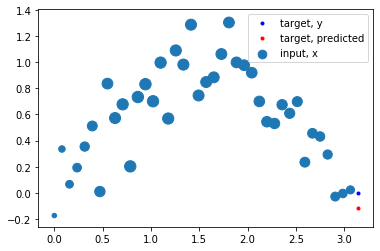

In [57]:
x = noisy_data[:-1] # all but the last piece of data
y = data[-1] # all but the first

# display the data
plt.scatter(time_steps[:-1], x, label='input, x', s=((norm_fm/0.02)*100)) # x
plt.plot(time_steps[-1], y, 'b.', label='target, y') # y
plt.plot(time_steps[-1], predicted[-1], 'r.', label='target, predicted') # predicted

plt.legend(loc='best')
plt.show()